# Default Probablity Analysis

Data collected by banks on several pieces of client information such as:\
• Marriage status\
• Amount of credit given in the credit card\
• Gender and Age\
• A few other credit history features such as payment delays for previous months\

*Target Value*: Default payment next month. This is the probability estimated by the bank on whether a given customer will default. Our aim is to predict that binary target variable.

In [ ]:
import io
import pandas as pd
import requests

In [201]:
# You might need this library to read Excel (or might not)
! pip install xlrd

In [202]:
# data_url=''
# data_stream=requests.get(data_url).content

df=pd.read_excel('./default of credit card clients.xls', header=1, index_col=0)

# Maybe in a non-Unix system (e.g. Windows) this path doesn't work. Check with \ instead of /

In [203]:
# Added the inplace parameter to True to keep the target label in the df. Also changed var name to "Default".
df.rename(columns={'default payment next month': 'Default'}, inplace= True)

In [204]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Exploratory Data Analysis

1. We can do a bunch of stuff with the data, but the right approach is to answer some questions and answering by visualization.

2. We have to model the probability of default, by classifying the clients based on some financial data. Let's begin by exploring what data are available.

In [205]:
df.columns # Print the columns of the dataset, these are the financial data of each client.

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Default'],
      dtype='object')

We can't understand a lot by the columns' name, so we have to check the description of the dataset in https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

The description of each column states:

- LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

- SEX: Gender (1 = male; 2 = female).

- EDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

- MARRIAGE: Marital status (1 = married; 2 = single; 3 = others).

- AGE: Age (year).

- PAY0 TO PAY6: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

- BILL_AMT1 TO BILL_AMT6: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.

- PAY_AMT1 TO PAY_AMT6: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.


In [206]:
# We can now check if everything is correct in our data. Let's check the unique values for each feature.
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")  

Unique values in column 'LIMIT_BAL': [  20000  120000   90000   50000  500000  100000  140000  200000  260000
  630000   70000  250000  320000  360000  180000  130000  450000   60000
  230000  160000  280000   10000   40000  210000  150000  380000  310000
  400000   80000  290000  340000  300000   30000  240000  470000  480000
  350000  330000  110000  420000  170000  370000  270000  220000  190000
  510000  460000  440000  410000  490000  390000  580000  600000  620000
  610000  700000  670000  680000  430000  550000  540000 1000000  530000
  710000  560000  520000  750000  640000   16000  570000  590000  660000
  720000  327680  740000  800000  760000  690000  650000  780000  730000]
Unique values in column 'SEX': [2 1]
Unique values in column 'EDUCATION': [2 1 3 5 4 6 0]
Unique values in column 'MARRIAGE': [1 2 3 0]
Unique values in column 'AGE': [24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 6

In [207]:
# There is a problem in the EDUCATION and MARRIAGE columns. Let's fix it. We assume Education categories not stated can be part of others(4) and the same goes with Marriage.
df.loc[df['EDUCATION'].isin([5, 6, 0]), 'EDUCATION'] = 4
df.loc[df['MARRIAGE'] == 0, 'MARRIAGE'] = 3

# Also PAY0-6 has a value -2 that is in reality other (0).
for col in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
  df.loc[df[col] == -2, col] = 0

# Let's split the dataset in 2 categories, first part will be client info, second part will be financial history.
client_df = df[["SEX", "AGE", "EDUCATION", "MARRIAGE", "Default"]]
info_df = df.drop(["SEX", "AGE", "EDUCATION", "MARRIAGE"], axis=1)

In [208]:
# We will use the Seaborn library to visualize the results. 
!  pip install --upgrade seaborn

## Client Profile in terms of Default.

A default payment is in simple terms an overdue account. In most cases they arise when a debt owed by you has become overdue. The target value is if a client has payed their issued debt. 0 if they didn't pay and 1 if they paid. So i don't think this is if they bankrupted in general, just if they didn't pay the amount of debt issued by the end of the month (common for credit card users).

Let's start by an analysis of client info. Some initial good questions we could ask are:

1. Does gender have a significant impact on the likelihood of paying defaults?

2. Are clients with higher education levels less likely to pay defaults?

3. Does being married, single, or in other marital status influence the probability of paying defaults?

4. Are younger or older clients more likely to pay defaults?

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

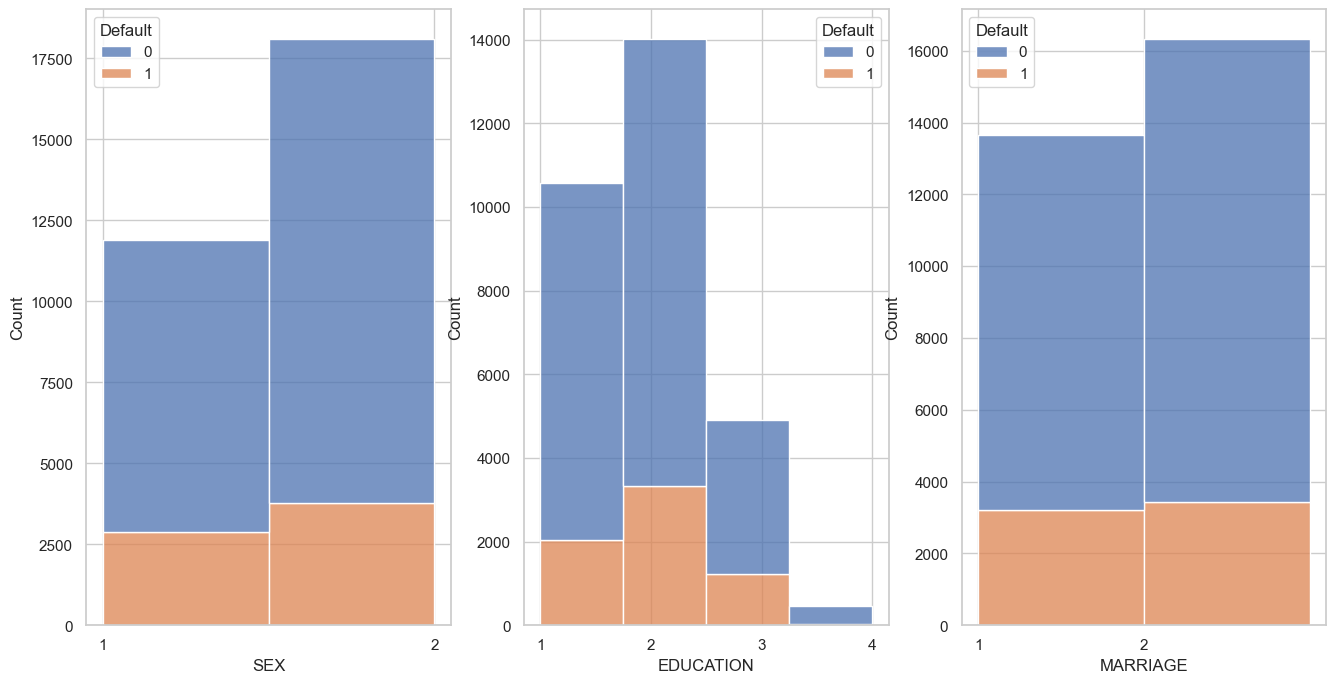

In [210]:
# Let's visualize the correlation by using plots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
sns.histplot(data = client_df, x="SEX", hue="Default", bins = 2, multiple ="stack", ax=axs[0])
axs[0].set_xticks([1,2])
sns.histplot(data = client_df, x="EDUCATION", hue="Default", bins = 4,multiple ="stack",  ax=axs[1])
axs[1].set_xticks([1,2,3,4])
sns.histplot(data = client_df, x="MARRIAGE", hue="Default", bins = 2,multiple ="stack", ax=axs[2])
axs[2].set_xticks([1,2])

plt.show()

The dataset might confuse some. 1 is the class of clients that haven't payed defaults. 0 is the class that did pay. 

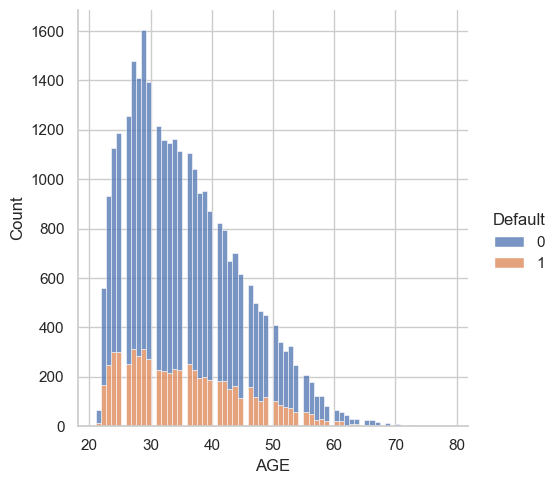

In [211]:
# Same for AGE correlation with default payments.
sns.displot(data = client_df, x = "AGE", hue = "Default", multiple ="stack")
plt.show()

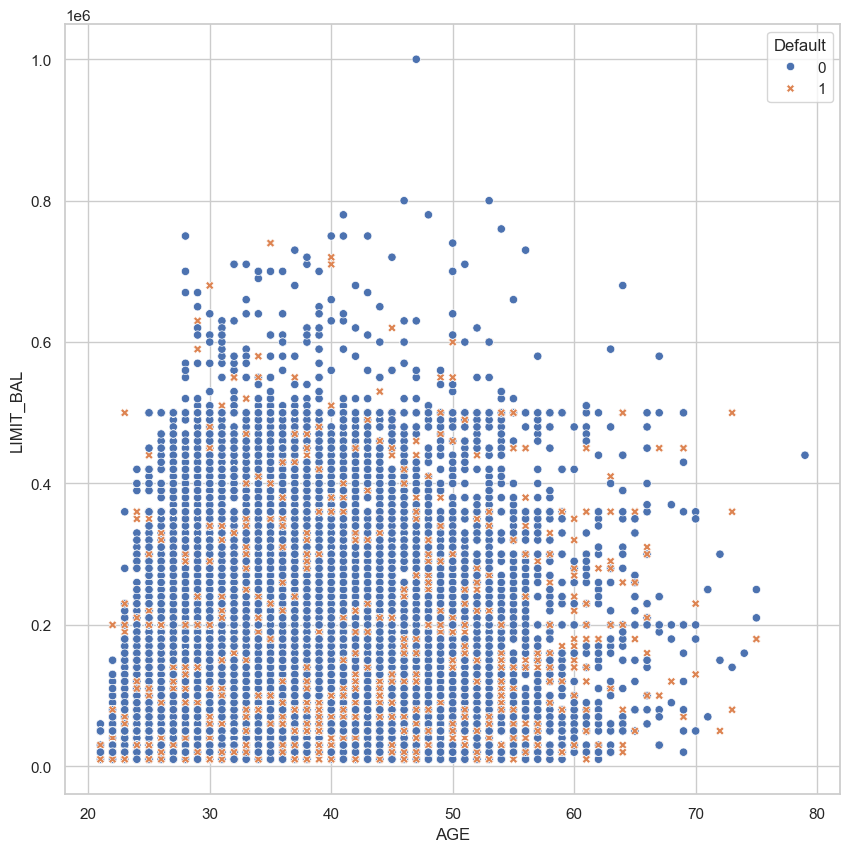

In [212]:
# Let's also create a scatter plot, showing the corellation between client's age and credit limit and we will categorize based on if they payed their default or not.
plt.figure(figsize=(10,10))
sns.scatterplot(data = df, x = "AGE", y = "LIMIT_BAL", hue = "Default", style = "Default")
plt.show()

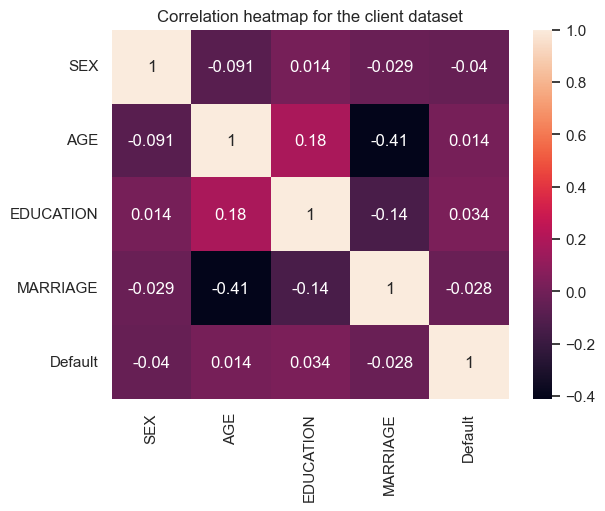

In [213]:
#Finally we can find the correlation between client characteristics.
sns.heatmap(client_df.corr(), annot=True)
plt.title('Correlation heatmap for the client dataset')
plt.show()

The blue section of the plots above refer to the clients that did not pay default, and the orange to the ones that did.

We observe, based on the features, that:
- Women are more likely to not pay their default than men.

- People in University pay the least often their default, if compared with people with less education.

- Marital status has no significant effect in default paying.

- People in age range of 25-30 are the ones that dont pay defaults the most.

- People with lower credit limit and slightly younger age seem to avoid paying default.

- No distinct feature is responsible for missing the default payment and mariage and age are negatively correlated in this dataset (not a usual phenomenon).  

We can construct with these insights, the profile of a client that is susceptible to not paying back their defaults.

## Financial History Analysis.

We can now obtain the patterns that people follow in terms of default payments.
Based on previous payments and bill statemets we will show what patterns the clients follow for their payments.



In [214]:
# Let's see some statistical info about financial history of the clients.
info_df.describe() 

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,0.167233,0.118367,0.106133,0.069200,0.036867,0.035233,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.931323,0.965844,0.950876,0.911613,0.864561,0.867919,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


First of all we can see that every feature has a huge standard deviation, thus the dataset has huge variability, indicating diverse data points within each metric. The mean value of Default is around 0.22, which could be interpreted as only 22% of the clients pay their defaults, in this dataset. This will create some sort of imbalance, which we will hopefully overcome. 


In [215]:
# To double check we can also count the values of each class. class 0 for the ones that didn't pay and 1 for the ones that did.
df["Default"].value_counts(normalize=True)


Default
0    0.7788
1    0.2212
Name: proportion, dtype: float64

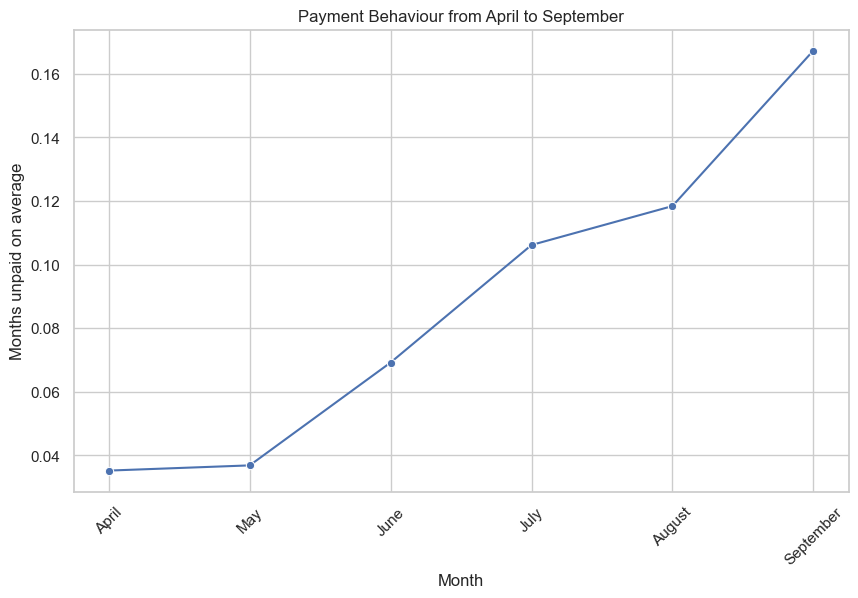

In [216]:
pay_columns = [col for col in info_df.columns if 'PAY' in col][0:6]
pay_means = df[pay_columns].mean().iloc[::-1]

months = ['April', 'May', 'June', 'July', 'August', 'September']

plt.figure(figsize=(10, 6))
sns.lineplot(x=months, y=pay_means.values, marker='o')
plt.title('Payment Behaviour from April to September')
plt.xlabel('Month')
plt.ylabel('Months unpaid on average')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

We observe that over a period of summer, the amount of people that don't pay their defaults is increasing (probably because of vacation spending!). From an average of 0.03 months unpaid in April, the clients reach on average 0.17 unpaid months in September. 

We will now check the amount of bill statement that the banks issue for their clients.

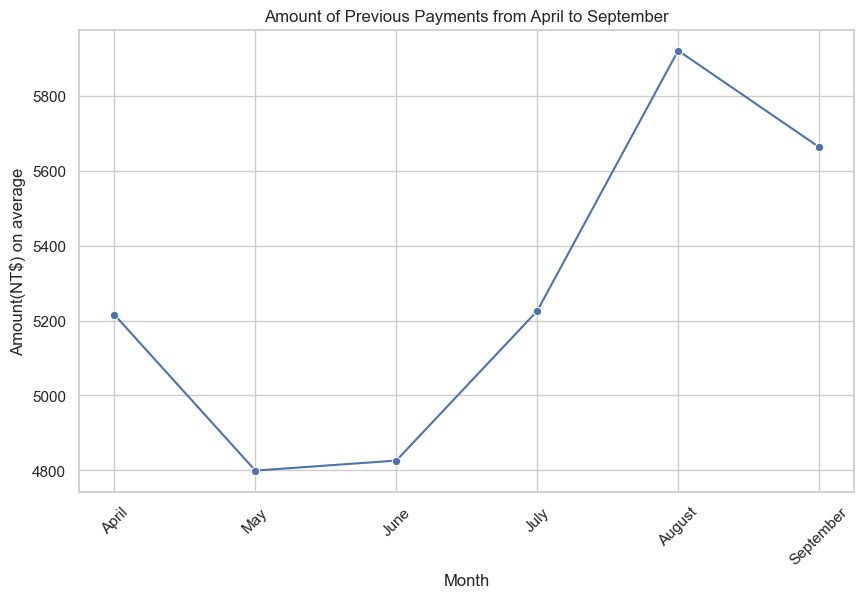

In [217]:
pay_amt_columns = [col for col in info_df.columns if 'PAY_AMT' in col]
pay_amt_means = df[pay_amt_columns].mean().iloc[::-1]

months = ['April', 'May', 'June', 'July', 'August', 'September']

plt.figure(figsize=(10, 6))
sns.lineplot(x=months, y=pay_amt_means.values, marker='o')
plt.title('Amount of Previous Payments from April to September')
plt.xlabel('Month')
plt.ylabel('Amount(NT$) on average')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The plot indicates that the amount that the clients had to pay to the bank was largely increased in the past 6 months, from 4800$ in May to over 5800$ in August, showing a larger need for credit by the clients in the summer months. This need is also correlated with the change in client behaviour that we saw previously.

Lastly, we will explore the total billing amount, to search for insights.

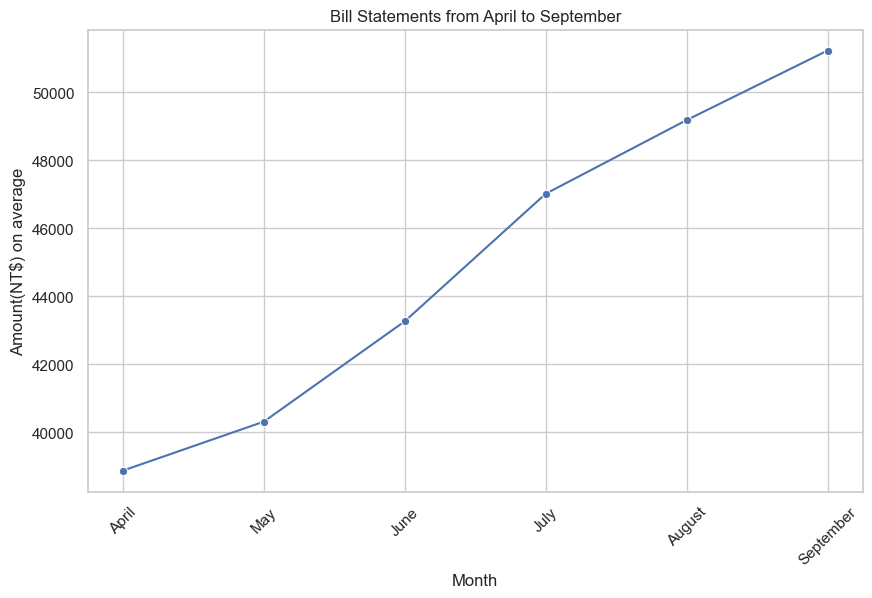

In [218]:
pay_amt_columns = [col for col in info_df.columns if 'BILL' in col]
pay_amt_means = df[pay_amt_columns].mean().iloc[::-1]

months = ['April', 'May', 'June', 'July', 'August', 'September']

plt.figure(figsize=(10, 6))
sns.lineplot(x=months, y=pay_amt_means.values, marker='o')
plt.title('Bill Statements from April to September')
plt.xlabel('Month')
plt.ylabel('Amount(NT$) on average')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The overall bill statements grew rapidly over the last 6 months, due to the seasonal needs of clients in the summer.

## Summary 

- The dataset could be indicatory for credit card client needs in summer, demand of capital is large and banks can form their policies based on that. 

- Various factors can lead to clients not paying back default. From the ones we explored in this dataset, we could create a profile that could indicate such behaviour, but bare in mind that the number one factor, as it seems, is the growing demand of cash in summer. Even so, our client (the bank) can use these insights to their advantage.

- There is a lot of complexity in this dataset, which shows the need of a complex statistical analysis to generate a safe classification model. ML algorithms seem necessary.

## Model Selection & Evaluation

The best way to find a ML model is to try a bunch of them and benchmark them against each other.

My plan would be to try training the models on three datasets.
1. The client info dataset
2. The financial history dataset

By differentiating the features selected, we value our decisiong making in 2 factors. The client profile and his historical data. But we do that independently!

My aim would be to benchmark the 2 models against a model that trains on the entire dataset to (hopefully!) see the benefits of feature selection.

Let's start by finding the best classifier for our dataset.

In [219]:
from sklearn.linear_model import LogisticRegression

# I will not use K-Neigbours as i am afraid of the speed in such large dataset. 

# I really want to see the Naive Bayes classifier, since we have highly independent features in the profiling dataset.  
from sklearn.naive_bayes import GaussianNB 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

Let's start by the profiling dataset

In [220]:
input_features = list(client_df.columns[:-1])
input_features # We will drop the last column, which is the target

['SEX', 'AGE', 'EDUCATION', 'MARRIAGE']

In [221]:
TRAIN_TEST_PERCENTAGE = 0.7
# Profile Info Selection
train, test = train_test_split(client_df, test_size=TRAIN_TEST_PERCENTAGE)

classifiers  = [LogisticRegression(C=1), GaussianNB(), DecisionTreeClassifier(criterion='gini', max_depth = 2), RandomForestClassifier(n_estimators=100, max_depth=5)]

for clf in classifiers:
  clf.fit(train[input_features],train['Default'])
  score = clf.score(test[input_features], test['Default'])
  print(str(clf), ": ",score)

LogisticRegression(C=1) :  0.781
GaussianNB() :  0.7807619047619048
DecisionTreeClassifier(max_depth=2) :  0.781
RandomForestClassifier(max_depth=5) :  0.7808095238095238


Basic Hyperparameter Tuning (mostly trial and error):
  1. Logistic Regression -> C parameter controls the regularization strength, which helps prevent overfitting by penalizing large coefficients.
  2. For NB we can't do much, just hard code the prior probablities, which we don't know.
  3. Decision Tree Classifier -> Gini impurity criterion, the lower it, the more info we gain after splitting. we will use a depth of 3, so we can easily visualize.
  4. Random Forrest Classifier -> 100 different trees, with a maximum depth of 5 on each.  



We can see that over 4 different algorithms, after trying a bunch of parameters, the classifiers' accuracy is around 78%. This suggests that the dataset may have limitations or characteristics that prevent the models from achieving higher accuracy. My guess is that the class imbalance introduces this problem. Or maybe a more complex algorithm is needed.

Due to explainability reasons, we can present the Decision tree we created for the profiling dataset.

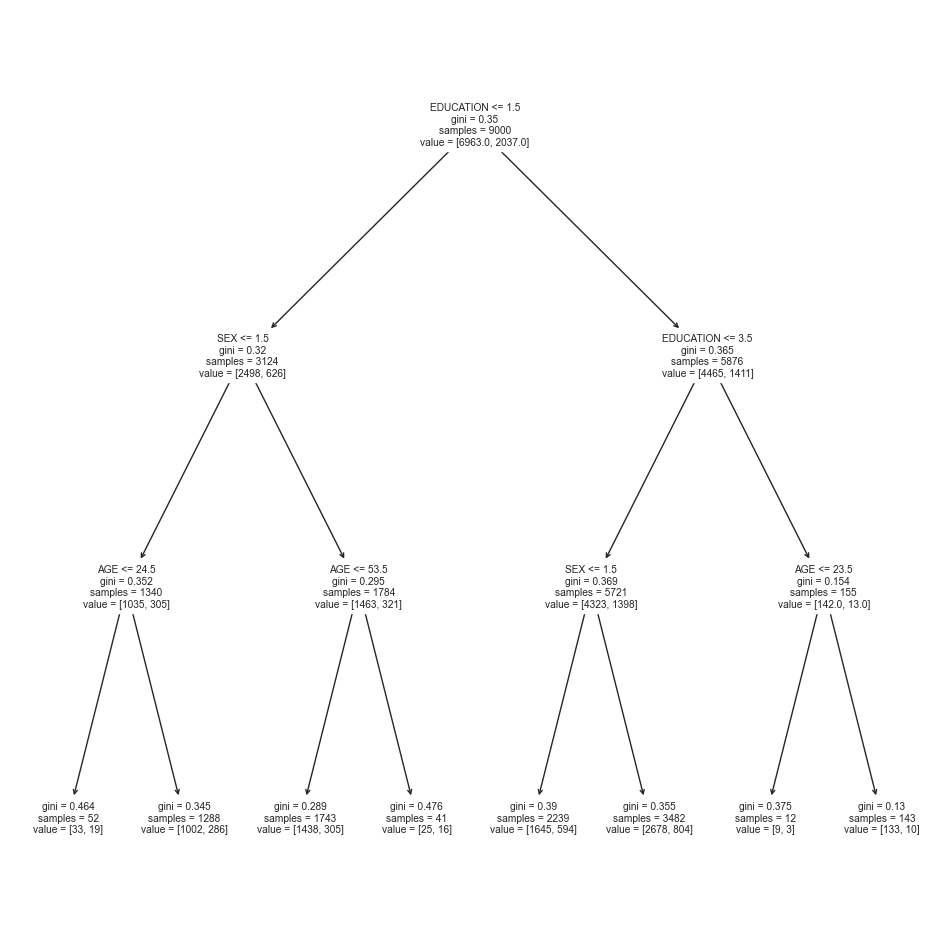

In [222]:
from sklearn.tree import plot_tree
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(train[input_features], train['Default'])
plt.figure(figsize=(12,12))  
plot_tree(tree, feature_names=client_df[:-1].columns)
plt.show()

We see that the algorithm uses age as the last criterion to make a choice, which we also saw how important was in the data exploration phase. Good sign! Gini in each split is somewhat low, which indicates a good information gain when we use the client profile to make decisions.

We will do the same algorithmic analysis, for the financial data.

In [223]:
# Financial Data selection
input_features = list(info_df.columns[:-1])
train, test = train_test_split(info_df, test_size=TRAIN_TEST_PERCENTAGE)

for clf in classifiers:
  clf.fit(train[input_features],train['Default'])
  score = clf.score(test[input_features], test['Default'])
  print(str(clf), ": ",score)

LogisticRegression(C=1) :  0.7777619047619048
GaussianNB() :  0.3943809523809524
DecisionTreeClassifier(max_depth=2) :  0.819047619047619
RandomForestClassifier(max_depth=5) :  0.8188095238095238


Let's start with the obvious. The Naive Bayes accuracy is really low. In Naive Bayes, the main assumption is that the features are independent, and thi is not the case in the financial history data. We saw earlier a huge correletaion to values over months and we explained its root. The NB accuracy confirms this correlation. 

On the other hand, we see an increase in the accuracy provided by Decision Tree and Random Forrest Classifiers.
This could drive the next phase of model and feature selection.

But first lets compare the accuracy obtained here, by actually using the whole dataset available.

In [224]:
# Financial Data selection
input_features = list(df.columns[:-1])
train, test = train_test_split(df, test_size=TRAIN_TEST_PERCENTAGE)

for clf in classifiers:
  clf.fit(train[input_features],train['Default'])
  score = clf.score(test[input_features], test['Default'])
  print(str(clf), ": ",score)

LogisticRegression(C=1) :  0.7784761904761904
GaussianNB() :  0.3585714285714286
DecisionTreeClassifier(max_depth=2) :  0.8178095238095238
RandomForestClassifier(max_depth=5) :  0.8175714285714286


We can clearly see that the financial data are the ones that have to drive the decision made by any of the algorithms we wish we continue to work with. We can now extend the perfomance metrics, by additional measurments, so we can see other ways we could optimize our model.

I would like to use all of the financial data AND some of the AGE/EDUCATION/SEX features, to augment them. 

In [225]:
final_df = df.drop(["EDUCATION", "MARRIAGE"], axis=1)
final_df


,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,24,2,2,-1,-1,0,0,3913,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,26,-1,2,0,0,0,2,2682,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,34,0,0,0,0,0,0,29239,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,37,0,0,0,0,0,0,46990,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,57,-1,0,-1,0,0,0,8617,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,39,0,0,0,0,0,0,188948,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,43,-1,-1,-1,-1,0,0,1683,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,37,4,3,2,-1,0,0,3565,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


In [227]:
#Same as before, split data and create the 2 models that performed best. We will use the whole set of metrics we have learnt for more insight.

from sklearn.metrics import balanced_accuracy_score, classification_report

input_features = list(final_df.columns[:-1])
train, test = train_test_split(final_df, test_size=TRAIN_TEST_PERCENTAGE)

classifiers = [DecisionTreeClassifier(criterion='gini', max_depth=2,), RandomForestClassifier(n_estimators=100, max_depth=5)]
for clf in classifiers:
  clf.fit(train[input_features],train['Default'])
  print("Balanced Accuracy Scores for", str(clf), ":")
  predictions = clf.predict(test[input_features])
  print(balanced_accuracy_score(test['Default'], predictions))
  print('Classification report for ', str(clf), '\n')
  print(classification_report(test['Default'], predictions))

Balanced Accuracy Scores for DecisionTreeClassifier(max_depth=2) :
0.6425948107947177
Classification report for  DecisionTreeClassifier(max_depth=2) 

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16344
           1       0.70      0.33      0.44      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.64      0.67     21000
weighted avg       0.80      0.82      0.79     21000

Balanced Accuracy Scores for RandomForestClassifier(max_depth=5) :
0.6288010102386323
Classification report for  RandomForestClassifier(max_depth=5) 

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16344
           1       0.68      0.30      0.41      4656

    accuracy                           0.81     21000
   macro avg       0.76      0.63      0.65     21000
weighted avg       0.80      0.81      0.78     21000



We now see clearly where the problem resides. The algorithm really struggles classifying correctly the clients that actually don't pay their default. That's common between both of the algorithms, and the most urgent problem is the recall of classifying clients that don't pay (class 1). This means that we have to find a way to reduce the false negative results, thus we should consider adjusting our approach to better identify clients who are likely to default, possibly by tweaking our model or giving more attention to the data related to defaults. In a more technical sense, we could use a more advanced algorithm to improve the accuracy. 

## Summary 

We began by loading the dataset and splitting it into two parts: client information and financial history information. By Exploratory Data Analysis (EDA), we showed how demographic factors like gender, age, education, marital status, and credit amount correlate with default payment, which gave useful insights.

Then we used financial data to explore and perform statistical tests. We found out that the main factor that the default payments increased over the given period, was due to summer months and growing demand. By using these results we went on to try different ML algorithms to find what is best suited for our dataset.

We created 2 simple models that have an accuracy of nearly 82%. This is pretty good, given that the dataset has a lot of imbalance, with significantly more clients who do not default compared to those who do. This imbalance makes it challenging for the models to correctly identify clients who will default, as the models tend to be biased towards predicting the majority class. 

The key issue lies in the models' ability to correctly classify the clients who actually default. This should be stated first in a stakeholders/engineers meeting. Overall, our models have the potential to achieve even higher accuracy and provide more reliable predictions for client default risk.